# Make DC2 DDF catalog for sprinkler input

As part of the new sprinkler we want to just take in a catalog and create a general output truth catalog. To do the matching for this new sprinkler we still need to know what's in the simulated data that we will replace. But instead of using an instance catalog as input we need a general catalog that includes the galaxies and AGN with variability parameters for the AGN. The AGN information as well as SED information is cached in separate databases, but we can put them all together to make one file with all the necessary information for all objects in the DC2 DDF field.

In [1]:
import os
import pandas as pd
import numpy as np
import GCRCatalogs
import matplotlib as mpl
import matplotlib.pyplot as plt
from GCR import GCRQuery
from lsst.utils import getPackageDir
from lsst.sims.photUtils import Sed, Bandpass, BandpassDict
from sklearn.neighbors import NearestNeighbors

## Load cosmoDC2 galaxies in the DDF

In [2]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image_addon_knots')

In [3]:
quantity_list = ['galaxy_id',
                 'ra',
                 'dec',
                 'redshift_true',
                 'shear_1',
                 'shear_2_phosim',
                 'convergence',
                 'position_angle_true',
                 'size_disk_true',
                 'size_minor_disk_true',
                 'size_bulge_true',
                 'size_minor_bulge_true',
                 'sersic_disk',
                 'sersic_bulge',
                 'stellar_mass_disk',
                 'stellar_mass_bulge',
                 'stellar_mass',
                 'totalStarFormationRate',
                  'Mag_true_u_lsst_z0',
#                  'Mag_true_g_lsst_z0',
                  'Mag_true_r_lsst_z0',
#                  'Mag_true_i_lsst_z0',
                ]

In [4]:
data = catalog.get_quantities(quantity_list, filters=['ra < 53.755', 'ra > 52.495',
                                                      'dec < -27.55', 'dec > -28.65'])

In [5]:
data

{'dec': array([-27.95058264, -27.69249304, -27.85769245, ..., -28.13236368,
        -28.26529948, -28.49389842]),
 'totalStarFormationRate': array([2623878.5  , 4610795.   ,   10592.783, ...,   97245.62 ,
         162922.69 ,   15558.204], dtype=float32),
 'sersic_bulge': array([4., 4., 4., ..., 4., 4., 4.], dtype=float32),
 'Mag_true_r_lsst_z0': array([-15.099893, -14.982487, -13.01989 , ..., -16.664286, -15.774436,
        -16.50886 ], dtype=float32),
 'size_disk_true': array([1.3903744 , 1.4941871 , 2.377272  , ..., 0.06413852, 0.03913148,
        0.05414167], dtype=float32),
 'shear_1': array([-0.        , -0.        , -0.        , ..., -0.00341649,
         0.00058958,  0.02259426]),
 'size_minor_disk_true': array([0.73315555, 0.67089117, 0.9705715 , ..., 0.03878969, 0.03339223,
        0.03335597], dtype=float32),
 'stellar_mass_disk': array([5135591.  , 6849424.5 , 1003472.9 , ..., 3750294.5 ,  832641.06,
         953544.1 ], dtype=float32),
 'convergence': array([ 0.        ,  

### Get healpix ids

We will need these to open the correct SED files.

In [25]:
import healpy
def get_healpix_id(ra, dec):
    pix_id = healpy.ang2pix(32, ra, dec, nest=False, lonlat=True)
    return pix_id

In [27]:
len(data['ra'])

6194586

In [30]:
healpix_ids = get_healpix_id(data['ra'], data['dec'])

In [31]:
healpix_ids

array([8914, 8914, 8914, ..., 9043, 9043, 9043])

### Put galaxy information into pandas dataframe

In [10]:
galaxy_df = pd.DataFrame(data)

In [11]:
galaxy_df.head()

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,position_angle_true,galaxy_id,sersic_disk,redshift_true,ra,stellar_mass_bulge,size_bulge_true,size_minor_bulge_true,stellar_mass,shear_2_phosim
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5.135591e+06,0.000000,-13.647583,3.872094,1875000009,1.0,0.020617,52.545849,7396574.0,0.692787,0.654324,1.253216e+07,-0.000000
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6.849424e+06,0.000000,-13.789320,151.776670,1875000034,1.0,0.019394,52.623324,1097576.5,0.739462,0.674218,7.947000e+06,-0.000000
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1.003473e+06,0.000000,-11.321993,50.902277,1875000035,1.0,0.017482,52.681314,0.0,0.913097,0.896222,1.003473e+06,-0.000000
3,-27.599111,1.586908e+07,4.0,-16.026091,3.411983,-0.000000,3.347761,3.920008e+07,0.000000,-14.870754,174.550510,1875000055,1.0,0.017347,52.581461,9869368.0,1.537620,1.532605,4.906946e+07,-0.000000
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7.509686e+06,-0.000014,-13.690415,117.095584,1875000072,1.0,0.046867,52.737179,1162219.0,0.602592,0.566917,8.671905e+06,-0.000023


In [12]:
galaxy_df['healpix_id'] = healpix_ids

In [13]:
galaxy_df.head()

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,...,galaxy_id,sersic_disk,redshift_true,ra,stellar_mass_bulge,size_bulge_true,size_minor_bulge_true,stellar_mass,shear_2_phosim,healpix_id
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5.135591e+06,0.000000,-13.647583,...,1875000009,1.0,0.020617,52.545849,7396574.0,0.692787,0.654324,1.253216e+07,-0.000000,8914
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6.849424e+06,0.000000,-13.789320,...,1875000034,1.0,0.019394,52.623324,1097576.5,0.739462,0.674218,7.947000e+06,-0.000000,8914
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1.003473e+06,0.000000,-11.321993,...,1875000035,1.0,0.017482,52.681314,0.0,0.913097,0.896222,1.003473e+06,-0.000000,8914
3,-27.599111,1.586908e+07,4.0,-16.026091,3.411983,-0.000000,3.347761,3.920008e+07,0.000000,-14.870754,...,1875000055,1.0,0.017347,52.581461,9869368.0,1.537620,1.532605,4.906946e+07,-0.000000,8914
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7.509686e+06,-0.000014,-13.690415,...,1875000072,1.0,0.046867,52.737179,1162219.0,0.602592,0.566917,8.671905e+06,-0.000023,8914


### Match to a galaxy type

Fit to type from Goldstein et al. catalog. The Goldstein et al.
catalog labels host galaxies as one of
three types: 'elliptical', 'sc', or 'starburst'.
We will assign labels to potential host galaxies
in the DDF to better match the catalog.


#### Only keep galaxies above mass cut at 10^8 solar masses

Focus on larger galaxies to better match mass distribution in Mannucci et al. (2005) paper we will use to estimate SN rate.

In [14]:
mass_cut = np.where(np.log10(galaxy_df['stellar_mass']) >= 8.)[0]

Text(0, 0.5, 'Galaxy Count')

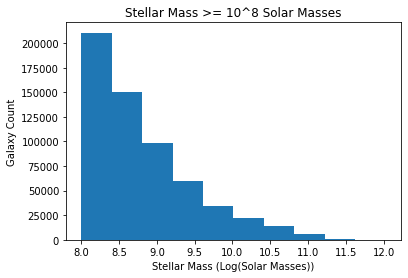

In [15]:
plt.hist(np.log10(galaxy_df['stellar_mass'][mass_cut]))
plt.title('Stellar Mass >= 10^8 Solar Masses')
plt.xlabel('Stellar Mass (Log(Solar Masses))')
plt.ylabel('Galaxy Count')

(array([-4., -2.,  0.,  2.,  4.,  6.,  8., 10., 12.]),
 <a list of 9 Text yticklabel objects>)

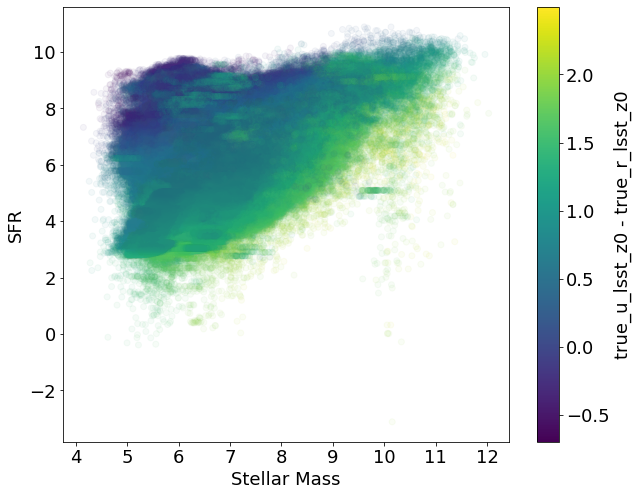

In [16]:
fig = plt.figure(figsize=(10,8))
plt.scatter(np.log10(galaxy_df['stellar_mass'][::10]),
            np.log10(data['totalStarFormationRate'][::10]),
            alpha=0.05, c=data['Mag_true_u_lsst_z0'][::10] - data['Mag_true_r_lsst_z0'][::10])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='true_u_lsst_z0 - true_r_lsst_z0', size=18)
cbar.set_alpha(1)
cbar.draw_all()
plt.xlabel('Stellar Mass', size=18)
plt.ylabel('SFR', size=18)
plt.xticks(size=18)
plt.yticks(size=18)

#### Divide galaxy types by regions of stellar mass vs star formation rate

Highest mass and lowest star formation rate will be ellipticals. Lowest mass and highest star formation rate will be starburst.

In [17]:
x_pts = np.arange(8, 12, 0.005)

Text(0.5, 1.0, 'Proposed Galaxy Type Boundaries')

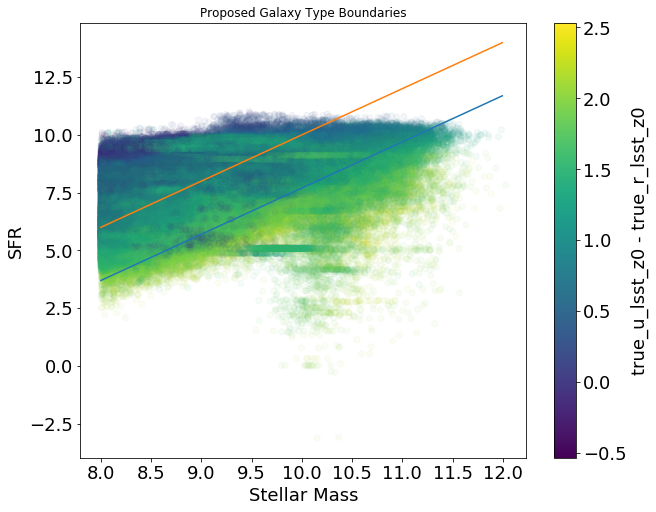

In [18]:
fig = plt.figure(figsize=(10,8))
plt.scatter(np.log10(data['stellar_mass'][mass_cut]),
            np.log10(data['totalStarFormationRate'][mass_cut]),
            alpha=0.05, c=data['Mag_true_u_lsst_z0'][mass_cut] - data['Mag_true_r_lsst_z0'][mass_cut])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_label(label='true_u_lsst_z0 - true_r_lsst_z0', size=18)
cbar.set_alpha(1)
cbar.draw_all()
plt.xlabel('Stellar Mass', size=18)
plt.ylabel('SFR', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.plot(x_pts, -12.3 + x_pts*2)
plt.plot(x_pts, -10 + x_pts*2)
plt.title('Proposed Galaxy Type Boundaries')

In [19]:
# We keep all galaxies even those below the stellar mass cut and just assign those
# below the minimum mass to type = -99 so we can identify them later
gal_type = np.ones(len(data['stellar_mass']))*-99

In [20]:
cut_val = np.log10(data['stellar_mass'][mass_cut])*2 - np.log10(data['totalStarFormationRate'][mass_cut])

In [21]:
gal_type[mass_cut[np.where(cut_val <= 10)]] = 2. #Starburst
gal_type[mass_cut[np.where((cut_val > 10) & (cut_val < 12.3))]] = 1. #SC
gal_type[mass_cut[np.where(cut_val >= 12.3)]] = 0. #Elliptical

In [22]:
gal_type[:10]

array([-99., -99., -99., -99., -99.,   0.,   0.,   2.,   0., -99.])

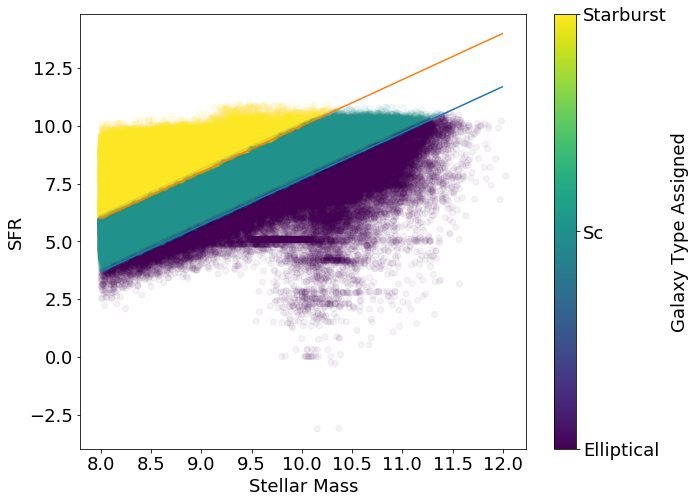

In [23]:
fig = plt.figure(figsize=(10,8))
plt.scatter(np.log10(data['stellar_mass'][mass_cut]),
            np.log10(data['totalStarFormationRate'][mass_cut]),
            alpha=0.05, c=gal_type[mass_cut])
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=18)
cbar.set_ticks([0, 1, 2])
cbar.set_ticklabels(['Elliptical', 'Sc', 'Starburst'])
cbar.set_label(label='Galaxy Type Assigned', size=18)
cbar.set_alpha(1)
cbar.draw_all()
plt.xlabel('Stellar Mass', size=18)
plt.ylabel('SFR', size=18)
plt.xticks(size=18)
plt.yticks(size=18)
plt.plot(x_pts, -12.3 + x_pts*2)
plt.plot(x_pts, -10 + x_pts*2)

Text(0.5, 1.0, 'Galaxy Type Assignments')

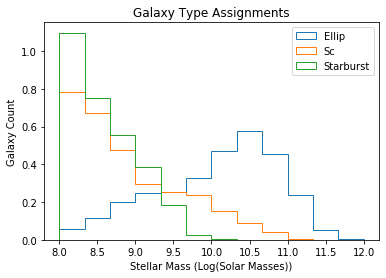

In [24]:
n, bins, _ = plt.hist(np.log10(data['stellar_mass'])[np.where(gal_type==0)], label='Ellip', histtype='step', range=(8.0, 12.), bins=12, density=True)
plt.hist(np.log10(data['stellar_mass'])[np.where(gal_type==1)], label='Sc', histtype='step', bins=bins, density=True)
plt.hist(np.log10(data['stellar_mass'])[np.where(gal_type==2)], label='Starburst', histtype='step', bins=bins, density=True)
plt.xlabel('Stellar Mass (Log(Solar Masses))')
plt.ylabel('Galaxy Count')
plt.legend()
plt.title('Galaxy Type Assignments')

In [25]:
kinney_types = ['kinney-elliptical', 'kinney-sc', 'kinney-starburst']

In [26]:
kinney_type_dict = {-99:'None', 0:'kinney-elliptical', 1:'kinney-sc', 2:'kinney-starburst'}

In [27]:
kinney_types_dc2 = []
for type_id in gal_type:
    kinney_types_dc2.append(kinney_type_dict[int(type_id)])

In [28]:
np.unique(kinney_types_dc2, return_counts=True)

(array(['None', 'kinney-elliptical', 'kinney-sc', 'kinney-starburst'],
       dtype='<U17'), array([5598709,   29750,  276167,  289960]))

In [29]:
galaxy_df['host_type'] = kinney_types_dc2

In [30]:
galaxy_df.head(10)

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,...,sersic_disk,redshift_true,ra,stellar_mass_bulge,size_bulge_true,size_minor_bulge_true,stellar_mass,shear_2_phosim,healpix_id,host_type
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5.135591e+06,0.000000,-13.647583,...,1.0,0.020617,52.545849,7.396574e+06,0.692787,0.654324,1.253216e+07,-0.000000,8914,None
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6.849424e+06,0.000000,-13.789320,...,1.0,0.019394,52.623324,1.097576e+06,0.739462,0.674218,7.947000e+06,-0.000000,8914,None
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1.003473e+06,0.000000,-11.321993,...,1.0,0.017482,52.681314,0.000000e+00,0.913097,0.896222,1.003473e+06,-0.000000,8914,None
3,-27.599111,1.586908e+07,4.0,-16.026091,3.411983,-0.000000,3.347761,3.920008e+07,0.000000,-14.870754,...,1.0,0.017347,52.581461,9.869368e+06,1.537620,1.532605,4.906946e+07,-0.000000,8914,None
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7.509686e+06,-0.000014,-13.690415,...,1.0,0.046867,52.737179,1.162219e+06,0.602592,0.566917,8.671905e+06,-0.000023,8914,None
5,-27.712304,4.033726e+05,4.0,-23.226475,29.920483,0.000002,27.935360,2.394919e+10,0.000082,-20.898287,...,1.0,0.047066,52.604145,3.178831e+11,18.749584,18.394707,3.418323e+11,0.000001,8914,kinney-elliptical
6,-27.698585,3.479801e+04,4.0,-19.433334,2.284488,-0.000010,2.017076,5.922428e+08,0.000096,-17.151030,...,1.0,0.047066,52.560131,4.518640e+09,1.244547,1.232981,5.110883e+09,0.000018,8914,kinney-elliptical
7,-27.604503,2.452688e+08,4.0,-17.189556,2.133967,-0.000010,1.216847,1.012820e+08,-0.000027,-15.417778,...,1.0,0.047066,52.940460,1.160316e+08,1.079106,1.031729,2.173136e+08,0.000013,8914,kinney-starburst
8,-27.759874,2.707374e+07,4.0,-21.450287,4.743254,-0.000037,2.871373,1.220466e+10,-0.000014,-19.152988,...,1.0,0.047066,52.648149,4.468104e+10,2.911081,2.304035,5.688570e+10,0.000034,8914,kinney-elliptical
9,-27.763610,5.657011e+03,4.0,-16.182764,1.142435,-0.000037,1.126129,3.865890e+07,-0.000003,-14.127932,...,1.0,0.047066,52.652109,1.210977e+07,0.544203,0.542182,5.076867e+07,0.000026,8914,None


In [2]:
scratch_dir = os.getenv('SCRATCH')

In [38]:
#galaxy_df.to_csv('%s/checkpoint.dat' % scratch_dir, index=False)

In [3]:
#galaxy_df = pd.read_csv('%s/checkpoint.dat' % scratch_dir)

## Get AGN database and save to pandas

In [4]:
import sqlite3

In [5]:
agn_db_file = '/global/cscratch1/sd/jchiang8/desc/Run2.2i/agn_catalog/2019-11-21/cosmoDC2_agn.db'

In [9]:
conn = sqlite3.connect(agn_db_file)

In [10]:
cur = conn.cursor()

In [11]:
cur.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cur.fetchall())

[('agn_params',)]


In [12]:
agn_df = pd.read_sql_query("SELECT * from agn_params", conn)

In [13]:
agn_df.head()

,galaxy_id,htmid_8,magNorm,varParamStr
0,1250000066,147063,24.015622,"{""m"": ""applyAgn"", ""p"": {""seed"": 5349672, ""agn_..."
1,1250000075,147070,18.155817,"{""m"": ""applyAgn"", ""p"": {""seed"": 5014835, ""agn_..."
2,1250000078,147070,22.357919,"{""m"": ""applyAgn"", ""p"": {""seed"": 6000625, ""agn_..."
3,1250000080,147070,24.532759,"{""m"": ""applyAgn"", ""p"": {""seed"": 7881169, ""agn_..."
4,1250000081,147057,18.708919,"{""m"": ""applyAgn"", ""p"": {""seed"": 1183889, ""agn_..."


In [14]:
agn_df.iloc[0]['varParamStr']

'{"m": "applyAgn", "p": {"seed": 5349672, "agn_sf_u": 2.599e+00, "agn_sf_g": 2.329e+00, "agn_sf_r": 2.480e+00, "agn_sf_i": 2.182e+00, "agn_sf_z": 1.775e+00, "agn_sf_y": 1.386e+00, "agn_tau_u" : 1.219e+01, "agn_tau_g" : 8.985e+02, "agn_tau_r" : 2.810e+02, "agn_tau_i" : 5.101e+01, "agn_tau_z" : 3.845e+02, "agn_tau_y" : 1.834e+02}}'

In [15]:
len(agn_df)

31008675

### Join databases on `galaxy_id`

In [16]:
galaxy_agn_join = galaxy_df.join(agn_df.set_index('galaxy_id'), on='galaxy_id')

In [17]:
galaxy_agn_join = galaxy_agn_join.rename(columns={'magNorm':'magNorm_agn', 'varParamStr':'varParamStr_agn'})

In [18]:
galaxy_agn_join.head(10)

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,...,stellar_mass_bulge,size_bulge_true,size_minor_bulge_true,stellar_mass,shear_2_phosim,healpix_id,host_type,htmid_8,magNorm_agn,varParamStr_agn
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5.135591e+06,0.000000,-13.647583,...,7.396574e+06,0.692787,0.654324,1.253216e+07,-0.000000,8914,None,NaN,NaN,NaN
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6.849424e+06,0.000000,-13.789320,...,1.097576e+06,0.739462,0.674218,7.947000e+06,-0.000000,8914,None,NaN,NaN,NaN
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1.003473e+06,0.000000,-11.321993,...,0.000000e+00,0.913097,0.896222,1.003473e+06,-0.000000,8914,None,NaN,NaN,NaN
3,-27.599111,1.586908e+07,4.0,-16.026090,3.411983,-0.000000,3.347761,3.920008e+07,0.000000,-14.870754,...,9.869368e+06,1.537620,1.532605,4.906946e+07,-0.000000,8914,None,NaN,NaN,NaN
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7.509686e+06,-0.000014,-13.690415,...,1.162219e+06,0.602592,0.566917,8.671905e+06,-0.000023,8914,None,NaN,NaN,NaN
5,-27.712304,4.033726e+05,4.0,-23.226475,29.920483,0.000002,27.935360,2.394919e+10,0.000082,-20.898287,...,3.178831e+11,18.749584,18.394707,3.418323e+11,0.000001,8914,kinney-elliptical,147051.0,17.633345,"{""m"": ""applyAgn"", ""p"": {""seed"": 5714248, ""agn_..."
6,-27.698585,3.479801e+04,4.0,-19.433334,2.284488,-0.000010,2.017076,5.922428e+08,0.000096,-17.151030,...,4.518640e+09,1.244547,1.232981,5.110883e+09,0.000018,8914,kinney-elliptical,NaN,NaN,NaN
7,-27.604503,2.452688e+08,4.0,-17.189556,2.133967,-0.000010,1.216847,1.012820e+08,-0.000027,-15.417778,...,1.160316e+08,1.079106,1.031729,2.173136e+08,0.000013,8914,kinney-starburst,NaN,NaN,NaN
8,-27.759874,2.707374e+07,4.0,-21.450287,4.743254,-0.000037,2.871373,1.220466e+10,-0.000014,-19.152988,...,4.468104e+10,2.911081,2.304035,5.688570e+10,0.000034,8914,kinney-elliptical,147051.0,22.150698,"{""m"": ""applyAgn"", ""p"": {""seed"": 6129072, ""agn_..."
9,-27.763610,5.657011e+03,4.0,-16.182764,1.142435,-0.000037,1.126129,3.865890e+07,-0.000003,-14.127932,...,1.210977e+07,0.544203,0.542182,5.076867e+07,0.000026,8914,None,NaN,NaN,NaN


### Calculate i-band mags for AGN

In [6]:
from lsst.sims.photUtils import Sed, BandpassDict, getImsimFluxNorm, Bandpass
from lsst.utils import getPackageDir
from copy import deepcopy

In [15]:
lsst_bp_dict = BandpassDict.loadTotalBandpassesFromFiles()

In [21]:
os.listdir(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), 'agnSED'))

['agn.spec.gz']

In [22]:
agn_sed = Sed()
agn_sed.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), 'agnSED', 'agn.spec.gz'))

In [23]:
mag_i_agn = []
for agn_data in galaxy_agn_join[['magNorm_agn', 'redshift_true']].values:
    agn_mag, agn_redshift = agn_data
    if np.isnan(agn_mag):
        mag_i_agn.append(np.nan)
        continue
    agn_copy = deepcopy(agn_sed)
    flux_norm = getImsimFluxNorm(agn_copy, agn_mag)
    agn_copy.multiplyFluxNorm(flux_norm)
    agn_copy.redshiftSED(agn_redshift, dimming=True)
    mag_i_agn.append(agn_copy.calcMag(lsst_bp_dict['i']))

In [24]:
galaxy_agn_join['mag_i_agn'] = mag_i_agn

In [27]:
galaxy_agn_join.head(10)

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,...,size_bulge_true,size_minor_bulge_true,stellar_mass,shear_2_phosim,healpix_id,host_type,htmid_8,magNorm_agn,varParamStr_agn,mag_i_agn
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5.135591e+06,0.000000,-13.647583,...,0.692787,0.654324,1.253216e+07,-0.000000,8914,None,NaN,NaN,NaN,NaN
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6.849424e+06,0.000000,-13.789320,...,0.739462,0.674218,7.947000e+06,-0.000000,8914,None,NaN,NaN,NaN,NaN
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1.003473e+06,0.000000,-11.321993,...,0.913097,0.896222,1.003473e+06,-0.000000,8914,None,NaN,NaN,NaN,NaN
3,-27.599111,1.586908e+07,4.0,-16.026090,3.411983,-0.000000,3.347761,3.920008e+07,0.000000,-14.870754,...,1.537620,1.532605,4.906946e+07,-0.000000,8914,None,NaN,NaN,NaN,NaN
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7.509686e+06,-0.000014,-13.690415,...,0.602592,0.566917,8.671905e+06,-0.000023,8914,None,NaN,NaN,NaN,NaN
5,-27.712304,4.033726e+05,4.0,-23.226475,29.920483,0.000002,27.935360,2.394919e+10,0.000082,-20.898287,...,18.749584,18.394707,3.418323e+11,0.000001,8914,kinney-elliptical,147051.0,17.633345,"{""m"": ""applyAgn"", ""p"": {""seed"": 5714248, ""agn_...",17.251804
6,-27.698585,3.479801e+04,4.0,-19.433334,2.284488,-0.000010,2.017076,5.922428e+08,0.000096,-17.151030,...,1.244547,1.232981,5.110883e+09,0.000018,8914,kinney-elliptical,NaN,NaN,NaN,NaN
7,-27.604503,2.452688e+08,4.0,-17.189556,2.133967,-0.000010,1.216847,1.012820e+08,-0.000027,-15.417778,...,1.079106,1.031729,2.173136e+08,0.000013,8914,kinney-starburst,NaN,NaN,NaN,NaN
8,-27.759874,2.707374e+07,4.0,-21.450287,4.743254,-0.000037,2.871373,1.220466e+10,-0.000014,-19.152988,...,2.911081,2.304035,5.688570e+10,0.000034,8914,kinney-elliptical,147051.0,22.150698,"{""m"": ""applyAgn"", ""p"": {""seed"": 6129072, ""agn_...",21.769157
9,-27.763610,5.657011e+03,4.0,-16.182764,1.142435,-0.000037,1.126129,3.865890e+07,-0.000003,-14.127932,...,0.544203,0.542182,5.076867e+07,0.000026,8914,None,NaN,NaN,NaN,NaN


## Load cached SED information

In [28]:
print(np.unique(healpix_ids))

[8914, 8915, 9043]


In [4]:
sed_dir = '/global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup'

In [5]:
import h5py
f = h5py.File(os.path.join(sed_dir, 'sed_fit_8914.h5'))

In [6]:
! ls /global/projecta/projectdirs/lsst/groups/SSim/DC2/cosmoDC2_v1.1.4/sedLookup

sed_fit_10066.h5  sed_fit_10449.h5  sed_fit_9171.h5  sed_fit_9560.h5
sed_fit_10067.h5  sed_fit_10450.h5  sed_fit_9172.h5  sed_fit_9561.h5
sed_fit_10068.h5  sed_fit_10451.h5  sed_fit_9173.h5  sed_fit_9562.h5
sed_fit_10069.h5  sed_fit_10452.h5  sed_fit_9174.h5  sed_fit_9681.h5
sed_fit_10070.h5  sed_fit_8786.h5   sed_fit_9175.h5  sed_fit_9682.h5
sed_fit_10071.h5  sed_fit_8787.h5   sed_fit_9176.h5  sed_fit_9683.h5
sed_fit_10072.h5  sed_fit_8788.h5   sed_fit_9177.h5  sed_fit_9684.h5
sed_fit_10073.h5  sed_fit_8789.h5   sed_fit_9178.h5  sed_fit_9685.h5
sed_fit_10074.h5  sed_fit_8790.h5   sed_fit_9298.h5  sed_fit_9686.h5
sed_fit_10193.h5  sed_fit_8791.h5   sed_fit_9299.h5  sed_fit_9687.h5
sed_fit_10194.h5  sed_fit_8792.h5   sed_fit_9300.h5  sed_fit_9688.h5
sed_fit_10195.h5  sed_fit_8793.h5   sed_fit_9301.h5  sed_fit_9689.h5
sed_fit_10196.h5  sed_fit_8794.h5   sed_fit_9302.h5  sed_fit_9690.h5
sed_fit_10197.h5  sed_fit_8913.h5   sed_fit_9303.h5  sed_fit_9810.h5
sed_fit_10198.h5  sed_fit_8914.h5 

In [7]:
list(f.keys())

['bulge_av',
 'bulge_fluxes',
 'bulge_magnorm',
 'bulge_rv',
 'bulge_sed',
 'dec',
 'disk_av',
 'disk_fluxes',
 'disk_magnorm',
 'disk_rv',
 'disk_sed',
 'galaxy_id',
 'ra',
 'redshift',
 'sed_names',
 'tot_fluxes']

In [8]:
sed_df = pd.DataFrame([], columns=['bulge_av',
 'bulge_rv',
 'bulge_sed',
 'disk_av',
 'disk_rv',
 'disk_sed',
 'galaxy_id',])

In [9]:
for hpix in [8914, 8915, 9043]:
    f = h5py.File(os.path.join(sed_dir, 'sed_fit_%i.h5' % hpix))
    
    sed_hpix_df = pd.DataFrame([])

    band_list = ['u', 'g', 'r', 'i', 'z', 'y']
    sed_names = f['sed_names'][()]
    for key in list(f.keys()):
        print(key, f[key].len())
        if (key.endswith('fluxes') or key.endswith('magnorm')):
            key_data = f[key][()]
            for i in range(6):
                sed_hpix_df[str(key + '_' + band_list[i])] = key_data[i]
        elif key in ['sed_names', 'ra', 'dec']:
            continue
        elif key.endswith('sed'):
            sed_hpix_df[key] = [sed_names[idx] for idx in f[key][()]]
        else:
            sed_hpix_df[key] = f[key][()]
            
    sed_df = pd.concat([sed_df, sed_hpix_df])

bulge_av 17251417
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17251417
bulge_sed 17251417
dec 17251417
disk_av 17251417
disk_fluxes 6
disk_magnorm 6
disk_rv 17251417
disk_sed 17251417
galaxy_id 17251417
ra 17251417
redshift 17251417
sed_names 959
tot_fluxes 6


/global/common/cori_cle7/software/jupyter/19-09/lib/python3.7/site-packages/ipykernel/__main__.py:21: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



bulge_av 17215541
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17215541
bulge_sed 17215541
dec 17215541
disk_av 17215541
disk_fluxes 6
disk_magnorm 6
disk_rv 17215541
disk_sed 17215541
galaxy_id 17215541
ra 17215541
redshift 17215541
sed_names 959
tot_fluxes 6
bulge_av 17182059
bulge_fluxes 6
bulge_magnorm 6
bulge_rv 17182059
bulge_sed 17182059
dec 17182059
disk_av 17182059
disk_fluxes 6
disk_magnorm 6
disk_rv 17182059
disk_sed 17182059
galaxy_id 17182059
ra 17182059
redshift 17182059
sed_names 959
tot_fluxes 6


In [10]:
sed_df = sed_df.reset_index(drop=True)

In [164]:
sed_df.tail()

,bulge_av,bulge_fluxes_g,bulge_fluxes_i,bulge_fluxes_r,bulge_fluxes_u,bulge_fluxes_y,bulge_fluxes_z,bulge_magnorm_g,bulge_magnorm_i,bulge_magnorm_r,...,disk_rv,disk_sed,galaxy_id,redshift,tot_fluxes_g,tot_fluxes_i,tot_fluxes_r,tot_fluxes_u,tot_fluxes_y,tot_fluxes_z
51649012,0.1,1.195065e-10,5.756698e-10,4.683465e-10,2.969855e-13,6.298569e-10,6.082738e-10,30.313428,30.176097,30.157882,...,2.8,b'galaxySED/Inst.10E08.04Z.spec.gz',2583392369,2.998998,5.457688e-10,1.575521e-09,1.391104e-09,1.527954e-11,1.650882e-09,1.605731e-09
51649013,0.1,5.760691e-11,1.849146e-10,1.563647e-10,4.803618e-13,2.106535e-10,2.006460e-10,31.523507,31.325759,31.372035,...,2.2,b'galaxySED/Inst.80E07.02Z.spec.gz',2583392370,3.027994,8.145557e-11,2.330343e-10,2.021180e-10,1.527885e-12,2.600430e-10,2.477137e-10
51649014,0.1,8.821770e-12,1.018750e-10,6.179368e-11,1.068902e-13,1.342072e-10,1.216852e-10,30.968997,30.682875,30.666512,...,2.0,b'galaxySED/Burst.12E09.04Z.spec.gz',2583392371,2.998962,1.602818e-11,1.640794e-10,1.043041e-10,2.308652e-13,2.117171e-10,1.925084e-10
51649015,0.1,6.336324e-11,2.393461e-10,1.974423e-10,3.240230e-13,2.785019e-10,2.618319e-10,31.205463,31.030399,31.060750,...,2.0,b'galaxySED/Inst.16E08.02Z.spec.gz',2583392372,2.986596,1.076225e-10,3.399689e-10,2.868541e-10,2.088121e-12,3.867589e-10,3.674434e-10
51649016,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,inf,inf,inf,...,2.4,b'galaxySED/Inst.20E08.04Z.spec.gz',2583392373,3.001044,2.258873e-10,8.653887e-10,7.074302e-10,1.731760e-12,9.957343e-10,9.465834e-10


In [39]:
len(sed_df)

51649017

## Join databases on `galaxy_id`

In [40]:
full_join = galaxy_agn_join.join(sed_df.set_index('galaxy_id'), on='galaxy_id')

In [41]:
full_join.head(10)

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,...,disk_magnorm_z,disk_rv,disk_sed,redshift,tot_fluxes_g,tot_fluxes_i,tot_fluxes_r,tot_fluxes_u,tot_fluxes_y,tot_fluxes_z
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5.135591e+06,0.000000,-13.647583,...,20.477642,4.0,b'galaxySED/Exp.25E09.02Z.spec.gz',0.020709,0.000032,0.000061,0.000049,0.000012,0.000073,0.000068
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6.849424e+06,0.000000,-13.789320,...,19.941111,3.8,b'galaxySED/Exp.25E09.02Z.spec.gz',0.019261,0.000037,0.000060,0.000051,0.000016,0.000067,0.000064
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1.003473e+06,0.000000,-11.321993,...,21.916558,2.0,b'galaxySED/Exp.80E09.02Z.spec.gz',0.017699,0.000006,0.000013,0.000010,0.000002,0.000016,0.000015
3,-27.599111,1.586908e+07,4.0,-16.026090,3.411983,-0.000000,3.347761,3.920008e+07,0.000000,-14.870754,...,18.633536,2.9,b'galaxySED/Const.10E10.02Z.spec.gz',0.017156,0.000121,0.000197,0.000166,0.000055,0.000226,0.000213
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7.509686e+06,-0.000014,-13.690415,...,21.812307,4.0,b'galaxySED/Exp.25E09.02Z.spec.gz',0.044630,0.000005,0.000010,0.000008,0.000002,0.000011,0.000011
5,-27.712304,4.033726e+05,4.0,-23.226475,29.920483,0.000002,27.935360,2.394919e+10,0.000082,-20.898287,...,16.875877,3.8,b'galaxySED/Burst.10E10.1Z.spec.gz',0.044378,0.007280,0.021646,0.015266,0.001589,0.032623,0.027467
6,-27.698585,3.479801e+04,4.0,-19.433334,2.284488,-0.000010,2.017076,5.922428e+08,0.000096,-17.151030,...,20.195039,4.0,b'galaxySED/Inst.10E10.1Z.spec.gz',0.043418,0.000224,0.000662,0.000464,0.000051,0.000970,0.000824
7,-27.604503,2.452688e+08,4.0,-17.189556,2.133967,-0.000010,1.216847,1.012820e+08,-0.000027,-15.417778,...,20.075499,4.0,b'galaxySED/Const.12E10.04Z.spec.gz',0.045444,0.000032,0.000085,0.000059,0.000010,0.000135,0.000114
8,-27.759874,2.707374e+07,4.0,-21.450287,4.743254,-0.000037,2.871373,1.220466e+10,-0.000014,-19.152988,...,16.962426,4.0,b'galaxySED/Exp.62E09.1Z.spec.gz',0.044377,0.001442,0.004172,0.002977,0.000324,0.006293,0.005263
9,-27.763610,5.657011e+03,4.0,-16.182764,1.142435,-0.000037,1.126129,3.865890e+07,-0.000003,-14.127932,...,21.051351,4.0,b'galaxySED/Exp.80E09.02Z.spec.gz',0.045954,0.000012,0.000032,0.000023,0.000003,0.000044,0.000039


## Save file 

In [8]:
import pickle

In [43]:
with open('../../../data/full_ddf.pkl', 'wb') as f:
    pickle.dump(full_join, f)

### Add Milky Way Av, Rv values

In [93]:
with open('../../../data/full_ddf.pkl', 'rb') as f:
    full_join = pickle.load(f)

In [44]:
from lsst.sims.catUtils.dust.EBV import EBVbase
import numpy as np

In [45]:
ebvObj = EBVbase()

In [46]:
ebv_vals = ebvObj.calculateEbv(interp=True,
                               equatorialCoordinates=np.array([np.radians(full_join['ra']),
                                                               np.radians(full_join['dec'])]))

In [47]:
av_vals = 3.1 * ebv_vals

In [48]:
full_join['av_mw'] = av_vals
full_join['rv_mw'] = 3.1

In [50]:
with open('../../../data/full_ddf.pkl', 'wb') as f:
    pickle.dump(full_join, f)

In [51]:
full_join.columns

Index(['dec', 'totalStarFormationRate', 'sersic_bulge', 'Mag_true_r_lsst_z0',
       'size_disk_true', 'shear_1', 'size_minor_disk_true',
       'stellar_mass_disk', 'convergence', 'Mag_true_u_lsst_z0',
       'position_angle_true', 'galaxy_id', 'sersic_disk', 'redshift_true',
       'ra', 'stellar_mass_bulge', 'size_bulge_true', 'size_minor_bulge_true',
       'stellar_mass', 'shear_2_phosim', 'healpix_id', 'host_type', 'htmid_8',
       'magNorm_agn', 'varParamStr_agn', 'mag_i_agn', 'bulge_av',
       'bulge_fluxes_g', 'bulge_fluxes_i', 'bulge_fluxes_r', 'bulge_fluxes_u',
       'bulge_fluxes_y', 'bulge_fluxes_z', 'bulge_magnorm_g',
       'bulge_magnorm_i', 'bulge_magnorm_r', 'bulge_magnorm_u',
       'bulge_magnorm_y', 'bulge_magnorm_z', 'bulge_rv', 'bulge_sed',
       'disk_av', 'disk_fluxes_g', 'disk_fluxes_i', 'disk_fluxes_r',
       'disk_fluxes_u', 'disk_fluxes_y', 'disk_fluxes_z', 'disk_magnorm_g',
       'disk_magnorm_i', 'disk_magnorm_r', 'disk_magnorm_u', 'disk_magnorm_y',

### Add Flux values

To calculate fluxes we will follow the procedure found in the SED caching code from Scott Daniel here: https://github.com/LSSTDESC/sims_GCRCatSimInterface/blob/master/workspace/sed_cache/fit_sed.py

The fluxes from the SED cache will not match our values because after calculating those fluxes Scott calculates a normalization factor that is multiplied into the `magNorm` values to match cosmoDC2 colors. Our fluxes are calculated from the final `magNorm` values that are provided after this process occurs.

In [118]:
with open('../../../data/full_ddf.pkl', 'rb') as f:
    full_join = pickle.load(f)

In [42]:
import multiprocessing

In [111]:
def calc_fluxes(sed_name, magnorm_list, av, rv, av_mw, redshift, out_dict, tag):
    
    sed_fluxes_no_mw_list = []
    sed_fluxes_mw_list = []
    
    print(tag)
    
    for ii in range(len(sed_name)):

        sed_rest = Sed()
        sed_rest.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), sed_name[ii].decode()))  
        sed_fluxes_no_mw = []
        sed_fluxes_mw = []
        
        rest_a_x, rest_b_x = sed_rest.setupCCM_ab()
        red_ax_bx = None

        for idx, filt_name in list(enumerate(['u', 'g', 'r', 'i', 'z', 'y'])):

            sed_new = Sed(wavelen=sed_rest.wavelen, flambda=sed_rest.flambda)
            
            sed_flux_norm = getImsimFluxNorm(sed_new, magnorm_list[ii][idx])

            sed_new.multiplyFluxNorm(sed_flux_norm)

            #rest_a_x, rest_b_x = sed_new.setupCCM_ab()

            sed_new.addDust(rest_a_x, rest_b_x, A_v=av[ii], R_v=rv[ii])

            sed_new.redshiftSED(redshift[ii], dimming=True)

            sed_flux = sed_new.calcFlux(lsst_bp_dict['%s' % filt_name])
            sed_fluxes_no_mw.append(sed_flux)

            if red_ax_bx is None:
                red_a_x, red_b_x = sed_new.setupCCM_ab()
                red_ax_bx = [red_a_x, red_b_x]
                
            sed_new.addDust(red_ax_bx[0], red_ax_bx[1], A_v=av_mw[ii], R_v=3.1)
            sed_flux_mw = sed_new.calcFlux(lsst_bp_dict['%s' % filt_name])
            sed_fluxes_mw.append(sed_flux_mw)
            
        sed_fluxes_no_mw_list.append(sed_fluxes_no_mw)
        sed_fluxes_mw_list.append(sed_fluxes_mw)
        
    out_dict[tag] = (sed_fluxes_no_mw_list, sed_fluxes_mw_list)
    # return(sed_fluxes_list)
           

In [113]:
%%time

# Following Scott's code here: https://github.com/LSSTDESC/sims_GCRCatSimInterface/blob/master/workspace/sed_cache/fit_sed.py

test_magnorms = full_join[['disk_magnorm_u', 'disk_magnorm_g', 'disk_magnorm_r', 'disk_magnorm_i', 'disk_magnorm_z', 'disk_magnorm_y']].values
test_df = full_join[['disk_sed', 'disk_av', 'disk_rv', 'av_mw', 'redshift']].values

mgr = multiprocessing.Manager()
out_dict = mgr.dict()
d_gal = len(test_df)//16
p_list = []
for i_start in range(0, len(test_df), d_gal):
    s = slice(i_start, i_start+d_gal)
    p = multiprocessing.Process(target=calc_fluxes, args=(test_df[s, 0], test_magnorms[s], test_df[s, 1], 
                                                          test_df[s, 2], test_df[s, 3], test_df[s, 4], out_dict, i_start))
    p.start()
    p_list.append(p)
    
for p in p_list:
    p.join()
    
disk_sed_fluxes_no_mw = np.empty((len(test_df), 6))
disk_sed_fluxes_mw = np.empty((len(test_df), 6))
    
for i_start in out_dict.keys():
    s = slice(i_start, i_start+d_gal)
    disk_sed_fluxes_no_mw[s] = out_dict[i_start][0]
    disk_sed_fluxes_mw[s] = out_dict[i_start][1]

0
387161
774322
1161483
1548644
1935805
2322966
2710127
3097288
3484449
3871610
4258771
4645932
5033093
5420254
5807415
6194576
CPU times: user 1min 46s, sys: 14.6 s, total: 2min 1s
Wall time: 1h 40min 33s


In [115]:
np.savetxt('disk_fluxes_no_mw.dat', disk_sed_fluxes_no_mw)
np.savetxt('disk_fluxes_mw.dat', disk_sed_fluxes_mw)

In [119]:
for idx, filt_name in list(enumerate(['u', 'g', 'r', 'i', 'z', 'y'])):
    full_join['disk_fluxes_%s' % filt_name] = disk_sed_fluxes_mw[:,idx]
    full_join['disk_fluxes_%s_noMW' % filt_name] = disk_sed_fluxes_no_mw[:,idx]

In [120]:
full_join.head()

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,...,tot_fluxes_y,tot_fluxes_z,av_mw,rv_mw,disk_fluxes_u_noMW,disk_fluxes_g_noMW,disk_fluxes_r_noMW,disk_fluxes_i_noMW,disk_fluxes_z_noMW,disk_fluxes_y_noMW
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5135591.0,0.000000,-13.647583,...,0.000073,0.000068,0.025690,3.1,0.000009,0.000020,0.000027,0.000033,0.000035,0.000037
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6849424.5,0.000000,-13.789320,...,0.000067,0.000064,0.025492,3.1,0.000015,0.000034,0.000046,0.000055,0.000058,0.000060
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1003472.9,0.000000,-11.321993,...,0.000016,0.000015,0.028062,3.1,0.000002,0.000006,0.000010,0.000013,0.000015,0.000016
3,-27.599111,1.586908e+07,4.0,-16.026090,3.411983,-0.000000,3.347761,39200084.0,0.000000,-14.870754,...,0.000226,0.000213,0.026909,3.1,0.000052,0.000113,0.000152,0.000177,0.000191,0.000202
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7509685.5,-0.000014,-13.690415,...,0.000011,0.000011,0.027350,3.1,0.000002,0.000005,0.000007,0.000009,0.000010,0.000011


In [121]:
%%time

# Following Scott's code here: https://github.com/LSSTDESC/sims_GCRCatSimInterface/blob/master/workspace/sed_cache/fit_sed.py

test_magnorms = full_join[['bulge_magnorm_u', 'bulge_magnorm_g', 'bulge_magnorm_r', 'bulge_magnorm_i', 'bulge_magnorm_z', 'bulge_magnorm_y']].values
test_df = full_join[['bulge_sed', 'bulge_av', 'bulge_rv', 'av_mw', 'redshift']].values

mgr = multiprocessing.Manager()
out_dict = mgr.dict()
d_gal = len(test_df)//16
p_list = []
for i_start in range(0, len(test_df), d_gal):
    s = slice(i_start, i_start+d_gal)
    p = multiprocessing.Process(target=calc_fluxes, args=(test_df[s, 0], test_magnorms[s], test_df[s, 1], 
                                                          test_df[s, 2], test_df[s, 3], test_df[s, 4], out_dict, i_start))
    p.start()
    p_list.append(p)
    
for p in p_list:
    p.join()
    
bulge_sed_fluxes_no_mw = np.empty((len(test_df), 6))
bulge_sed_fluxes_mw = np.empty((len(test_df), 6))
    
for i_start in out_dict.keys():
    s = slice(i_start, i_start+d_gal)
    bulge_sed_fluxes_no_mw[s] = out_dict[i_start][0]
    bulge_sed_fluxes_mw[s] = out_dict[i_start][1]

0
387161
774322
1161483
1548644
1935805
2322966
2710127
3097288
3484449
3871610
4258771
4645932
5033093
5420254
5807415
6194576
CPU times: user 1min 58s, sys: 27.5 s, total: 2min 25s
Wall time: 1h 39min 44s


In [122]:
np.savetxt('bulge_fluxes_no_mw.dat', bulge_sed_fluxes_no_mw)
np.savetxt('bulge_fluxes_mw.dat', bulge_sed_fluxes_mw)

In [156]:
for idx, filt_name in list(enumerate(['u', 'g', 'r', 'i', 'z', 'y'])):
    full_join['bulge_fluxes_%s' % filt_name] = bulge_sed_fluxes_mw[:,idx]
    full_join['bulge_fluxes_%s_noMW' % filt_name] = bulge_sed_fluxes_no_mw[:,idx]

In [144]:
def calc_agn_fluxes(magnorm, av_mw, redshift, out_dict, tag):
    
    sed_fluxes_no_mw_list = []
    sed_fluxes_mw_list = []
    
    print(tag)

    sed_rest = Sed()
    sed_rest.readSED_flambda(os.path.join(getPackageDir('SIMS_SED_LIBRARY'), 'agnSED', 'agn.spec.gz'))  
    
    for ii in range(len(redshift)):

        sed_fluxes_no_mw = []
        sed_fluxes_mw = []
        
        red_ax_bx = None

        for idx, filt_name in list(enumerate(['u', 'g', 'r', 'i', 'z', 'y'])):

            sed_new = Sed(wavelen=sed_rest.wavelen, flambda=sed_rest.flambda)
            
            sed_flux_norm = getImsimFluxNorm(sed_new, magnorm[ii])

            sed_new.multiplyFluxNorm(sed_flux_norm)

            sed_new.redshiftSED(redshift[ii], dimming=True)

            sed_flux = sed_new.calcFlux(lsst_bp_dict['%s' % filt_name])
            sed_fluxes_no_mw.append(sed_flux)

            if red_ax_bx is None:
                red_a_x, red_b_x = sed_new.setupCCM_ab()
                red_ax_bx = [red_a_x, red_b_x]
                
            sed_new.addDust(red_ax_bx[0], red_ax_bx[1], A_v=av_mw[ii], R_v=3.1)
            sed_flux_mw = sed_new.calcFlux(lsst_bp_dict['%s' % filt_name])
            sed_fluxes_mw.append(sed_flux_mw)
            
        sed_fluxes_no_mw_list.append(sed_fluxes_no_mw)
        sed_fluxes_mw_list.append(sed_fluxes_mw)
        
    out_dict[tag] = (sed_fluxes_no_mw_list, sed_fluxes_mw_list)
    # return(sed_fluxes_list)
           
           

In [150]:
%%time

# Following Scott's code here: https://github.com/LSSTDESC/sims_GCRCatSimInterface/blob/master/workspace/sed_cache/fit_sed.py

test_magnorms = full_join[['magNorm_agn']].values
test_df = full_join[['av_mw', 'redshift']].values

mgr = multiprocessing.Manager()
out_dict = mgr.dict()
d_gal = len(test_df)//16
p_list = []
for i_start in range(0, len(test_df), d_gal):
    s = slice(i_start, i_start+d_gal)
    p = multiprocessing.Process(target=calc_agn_fluxes, args=(test_magnorms[s], test_df[s, 0], 
                                                              test_df[s, 1], out_dict, i_start))
    p.start()
    p_list.append(p)
    
for p in p_list:
    p.join()
    
agn_sed_fluxes_no_mw = np.empty((len(test_df), 6))
agn_sed_fluxes_mw = np.empty((len(test_df), 6))
    
for i_start in out_dict.keys():
    s = slice(i_start, i_start+d_gal)
    agn_sed_fluxes_no_mw[s] = out_dict[i_start][0]
    agn_sed_fluxes_mw[s] = out_dict[i_start][1]

0
387161
774322
1161483
1548644
1935805
2322966
2710127
3097288
3484449
3871610
4258771
4645932
5033093
5420254
5807415
6194576
CPU times: user 1min 51s, sys: 8.47 s, total: 1min 59s
Wall time: 1h 13min 48s


In [155]:
np.savetxt('agn_fluxes_no_mw.dat', agn_sed_fluxes_no_mw)
np.savetxt('agn_fluxes_mw.dat', agn_sed_fluxes_mw)

In [157]:
for idx, filt_name in list(enumerate(['u', 'g', 'r', 'i', 'z', 'y'])):
    full_join['agn_fluxes_%s' % filt_name] = agn_sed_fluxes_mw[:,idx]
    full_join['agn_fluxes_%s_noMW' % filt_name] = agn_sed_fluxes_no_mw[:,idx]

In [195]:
total_fluxes_mw = np.nansum([disk_sed_fluxes_mw, bulge_sed_fluxes_mw, agn_sed_fluxes_mw], axis=0)

In [196]:
total_fluxes_no_mw = np.nansum([disk_sed_fluxes_no_mw, bulge_sed_fluxes_no_mw, agn_sed_fluxes_no_mw], axis=0)

In [197]:
for idx, filt_name in list(enumerate(['u', 'g', 'r', 'i', 'z', 'y'])):
    full_join['total_fluxes_%s' % filt_name] = total_fluxes_mw[:,idx]
    full_join['total_fluxes_%s_noMW' % filt_name] = total_fluxes_no_mw[:,idx]

In [198]:
full_join.head()

,dec,totalStarFormationRate,sersic_bulge,Mag_true_r_lsst_z0,size_disk_true,shear_1,size_minor_disk_true,stellar_mass_disk,convergence,Mag_true_u_lsst_z0,...,total_fluxes_g,total_fluxes_g_noMW,total_fluxes_r,total_fluxes_r_noMW,total_fluxes_i,total_fluxes_i_noMW,total_fluxes_z,total_fluxes_z_noMW,total_fluxes_y,total_fluxes_y_noMW
0,-27.950583,2.623878e+06,4.0,-15.099893,1.390374,-0.000000,0.733156,5135591.0,0.000000,-13.647583,...,0.000032,0.000032,0.000048,0.000049,0.000061,0.000062,0.000067,0.000068,0.000072,0.000073
1,-27.692493,4.610795e+06,4.0,-14.982487,1.494187,-0.000000,0.670891,6849424.5,0.000000,-13.789320,...,0.000036,0.000037,0.000050,0.000051,0.000059,0.000060,0.000063,0.000064,0.000066,0.000067
2,-27.857692,1.059278e+04,4.0,-13.019890,2.377272,-0.000000,0.970572,1003472.9,0.000000,-11.321993,...,0.000006,0.000006,0.000010,0.000010,0.000013,0.000013,0.000015,0.000015,0.000016,0.000016
3,-27.599111,1.586908e+07,4.0,-16.026090,3.411983,-0.000000,3.347761,39200084.0,0.000000,-14.870754,...,0.000117,0.000121,0.000162,0.000166,0.000193,0.000197,0.000211,0.000213,0.000224,0.000226
4,-27.665230,5.564104e+06,4.0,-14.948131,1.470491,-0.000026,1.000541,7509685.5,-0.000014,-13.690415,...,0.000005,0.000006,0.000008,0.000008,0.000010,0.000010,0.000011,0.000011,0.000012,0.000012


## Save final version of catalog

In [199]:
with open('../../../data/full_ddf.pkl', 'wb') as f:
    pickle.dump(full_join, f)